<a href="https://colab.research.google.com/github/ziyuanli17/Automated-Atrium-Segmentation/blob/main/BME569_Final_Project_Slice_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydicom
!pip install tifffile
!pip install nibabel

import pydicom as dicom
import matplotlib.pylab as plt
import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.models import Sequential, Model
from keras.preprocessing import image

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l2, l1_l2

import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import skimage.io as io

from PIL import Image, ImageEnhance
from PIL import Image as im

import cv2
import cv2 as cv
from google.colab.patches import cv2_imshow
import os
import sys
from google.colab import drive
from IPython.display import clear_output 
from scipy.interpolate import splprep, splev
from scipy import spatial
 
import os
from glob import glob
import time
import re
import argparse
import nibabel as nib
import configparser
import pickle
import gc
import imageio
import tifffile

# **Software Parameters**

In [ ]:
# Required parameter to modify
slice_number = 6 # Select a slice with clear boundary between RA and LA, and LA with approximately circular shape (e.g. when it is most filled)

# Recomended parameter to modify (In case performence is not satisfactory)
erode_iterations = 5 # Number of iterations to erode (larger means more degree of erosion)
rotate_90_num = 0 # Number of times to rotate the images by 90 degrees (Should be adjusted until the LA is on top of RA)
debug_mode = True # Set to false to supress all outputs

# Optional parameter to modify (In case performence is not satisfactory)
# Note: the MRI data in this study was encoded with intensity ranging from 0 to 1000.
# Please adjust color limits below accordingly if the range changes (e.g. 0 to 255)
color1 = 225 # Lower color limit for color filtering
color2 = 800 # Upper color limit for color filtering
blockSize = 15 # Determines the size of the neighbourhood area 
C = 5 # A constant that is subtracted from the mean or weighted sum of the neighbourhood pixels
area1 = 150 # Lower area limit for black area filtering
area2 = 100 # Lower area limit for white area filtering
area3 = 8000 # Upper limit for whit area filtering
hough_thresh = 20 # Threshold for Hough circle detection (larger would increase the chance for a circular shape to be detected)
minR = 5 # Lower limit radius for circle detection
maxR = 18 # Upper limit radius for circle detection
outlier_threshold = 8 # Smaller value leads to more outliers being detected

print("Copyright (c) 2021 Ziyuan Li")
print("All Rights Reserved")

Copyright (c) 2021 Ziyuan Li
All Rights Reserved


# **Load and Preprocess Dicom**

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['58-SAX-cine_trufi_cs' '59-SAX-cine_trufi_cs' '60-SAX-cine_trufi_cs'
 '61-SAX-cine_trufi_cs' '62-SAX-cine_trufi_cs']
Spacing between slices 8
Spacing between slices 8
Spacing between slices 8
Spacing between slices 8
Spacing between slices 8
(5, 256, 256)


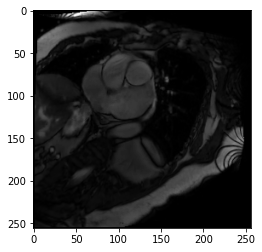

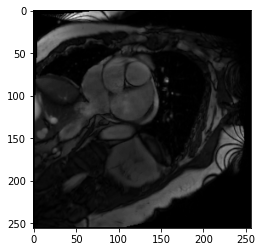

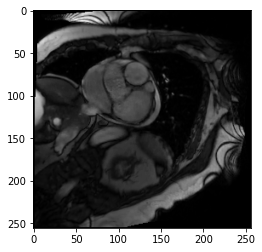

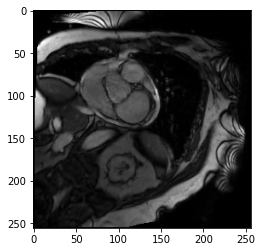

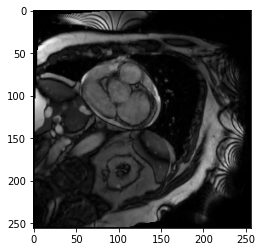

In [ ]:
if not debug_mode:
  %%capture

def read_dicom(main_folder, slice_num = None):
  # Iterate through folders
  seq_folders =np.array(os.listdir(main_folder))
  seq_folders.sort()
  print(seq_folders)
  full_series = []
  slice_locs = []
  for file_folder in seq_folders:
    dicom_name = os.listdir(main_folder+file_folder+"/resources"+"/DICOM")[0]
    ds = dicom.dcmread(main_folder+file_folder+"/resources"+"/DICOM"+"/"+dicom_name)
    print("Spacing between slices", ds.SpacingBetweenSlices)
    img_series = ds.pixel_array
    if slice_num is not None:
      img_series = img_series[slice_num, :, :]
      for i in range(rotate_90_num):
        img_series = np.rot90(img_series)
      plt.figure()
      plt.imshow(img_series, cmap="gray")
    full_series.append(img_series)
    slice_locs.append(ds.SpacingBetweenSlices)

  full_series = np.array(full_series)
  print(full_series.shape)
  return full_series, slice_locs

drive.mount('/content/gdrive')
path = '/content/gdrive/MyDrive/atria_MRI/'
img_series, slice_locs = read_dicom(path+"3/", slice_number)


# **Segmentation**

LA center


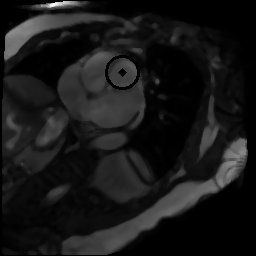

Color Filtered


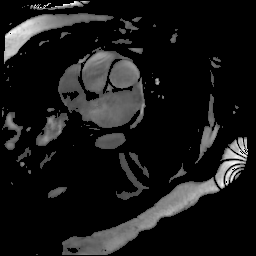

Adaptive Thresholded


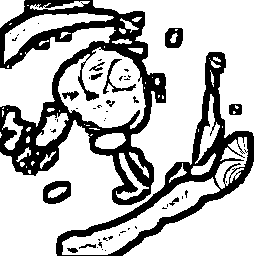

Black components filtered


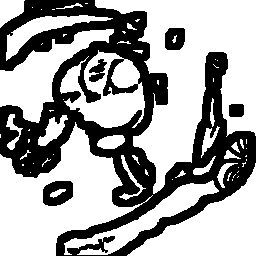

White components filtered


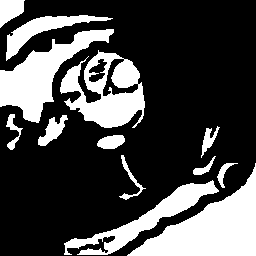

Eroded


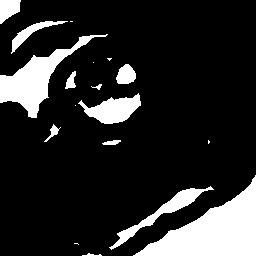

Black components filtered


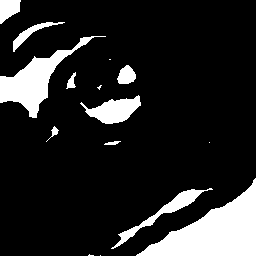

White components filtered


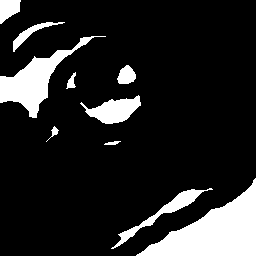

Localized 


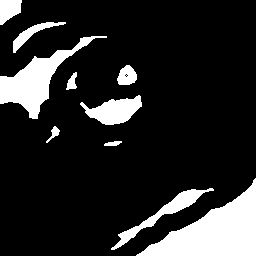

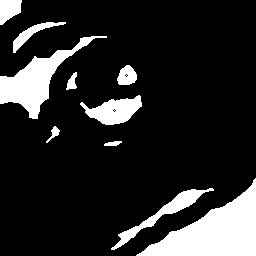

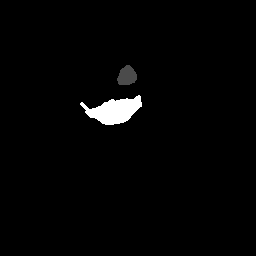

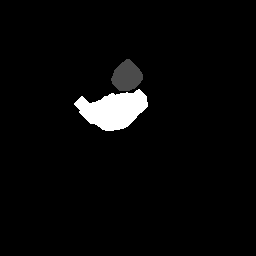

LA center


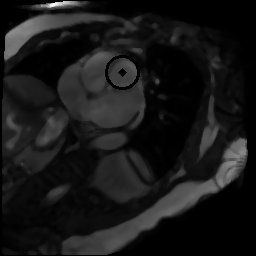

Color Filtered


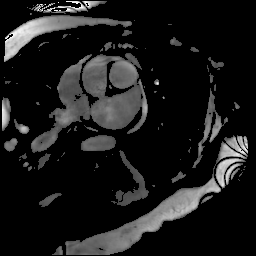

Adaptive Thresholded


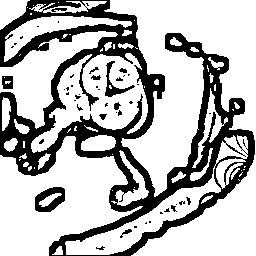

Black components filtered


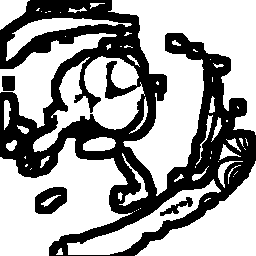

White components filtered


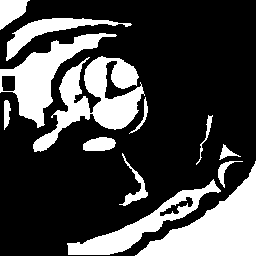

Eroded


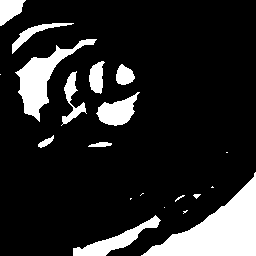

Black components filtered


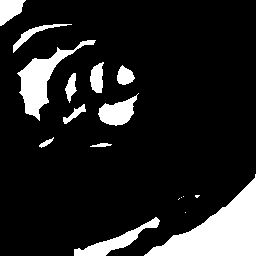

White components filtered


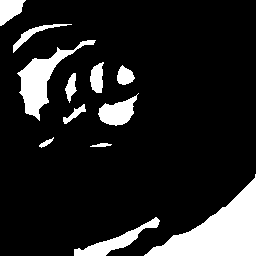

Localized 


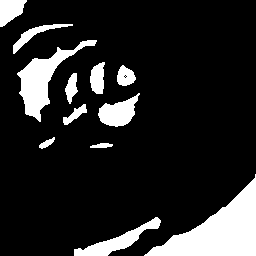

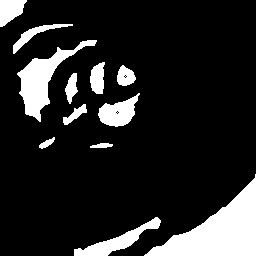

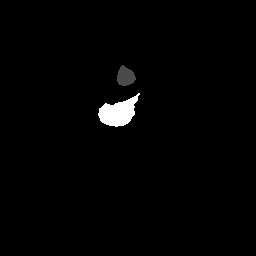

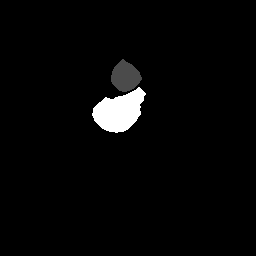

LA center


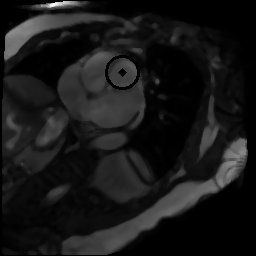

Color Filtered


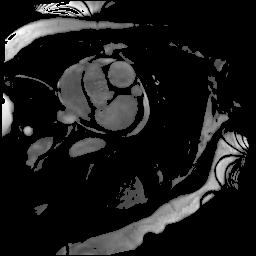

Adaptive Thresholded


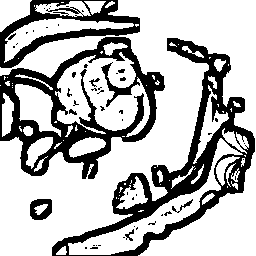

Black components filtered


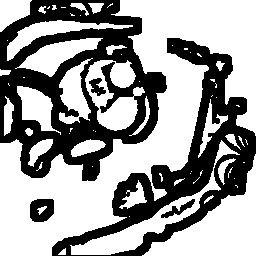

White components filtered


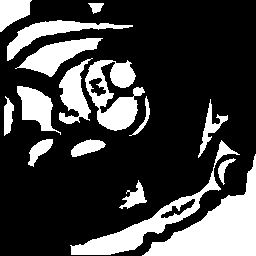

Eroded


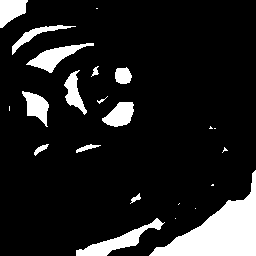

Black components filtered


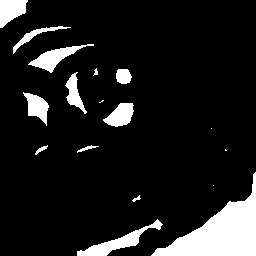

White components filtered


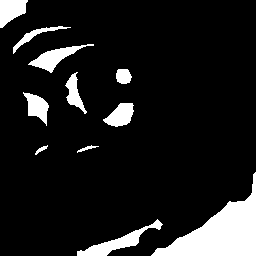

Localized 


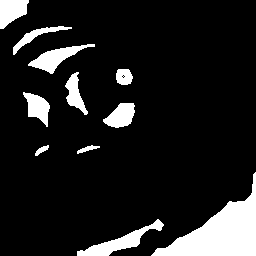

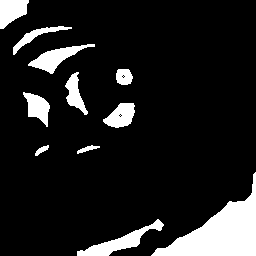

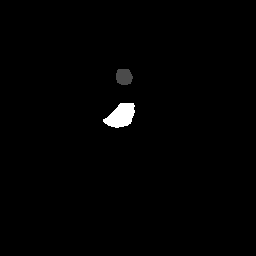

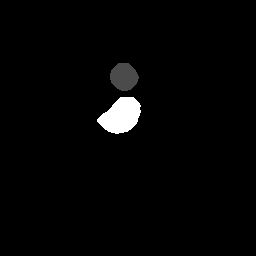

LA center


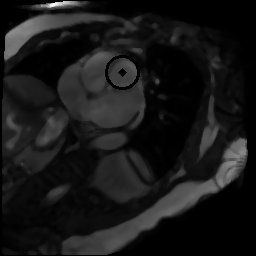

Color Filtered


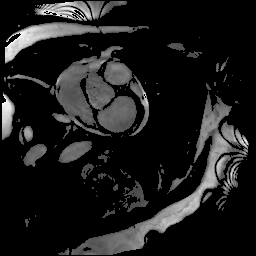

Adaptive Thresholded


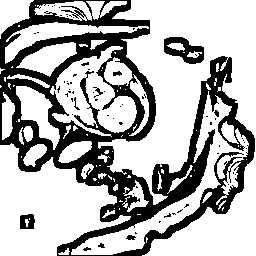

Black components filtered


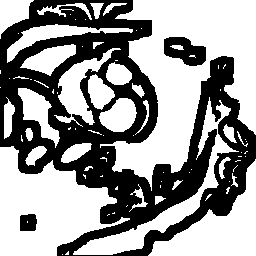

White components filtered


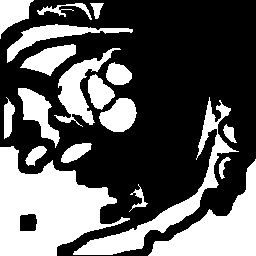

Eroded


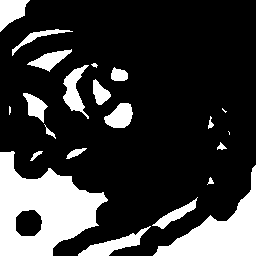

Black components filtered


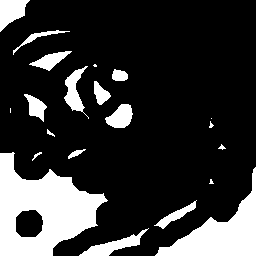

White components filtered


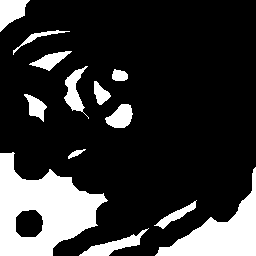

Localized 


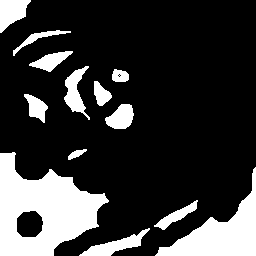

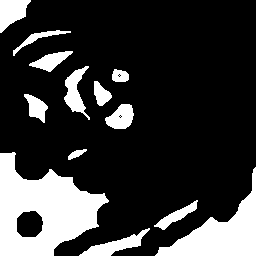

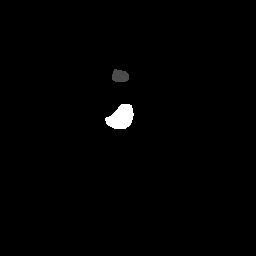

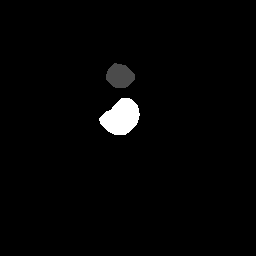

LA center


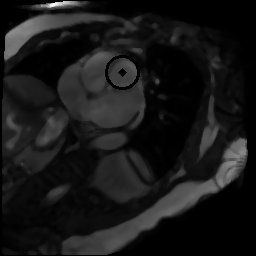

Color Filtered


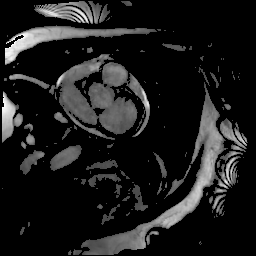

Adaptive Thresholded


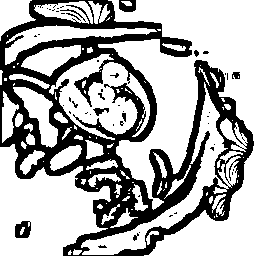

Black components filtered


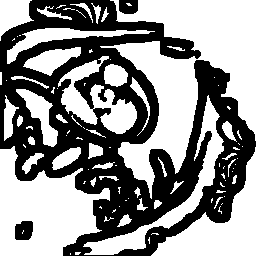

White components filtered


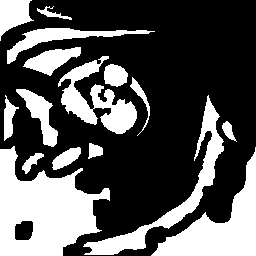

Eroded


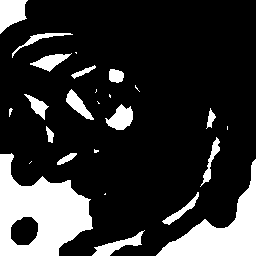

Black components filtered


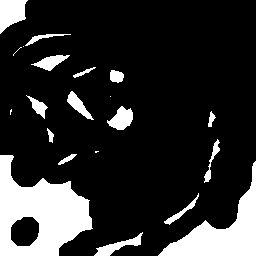

White components filtered


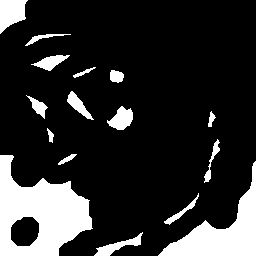

Localized 


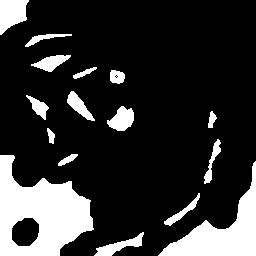

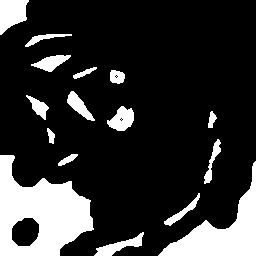

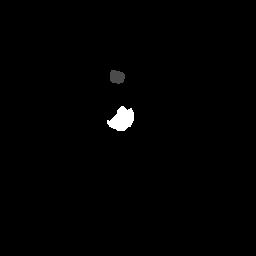

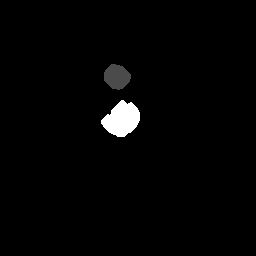

(5, 256, 256)
Accepted segmentation masks: 
Slice location:  5


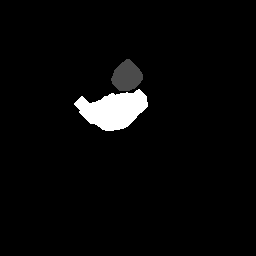

Slice location:  10


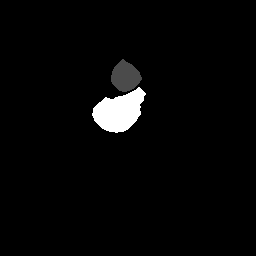

Slice location:  15


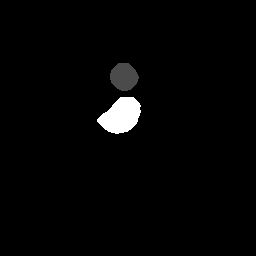

Slice location:  20


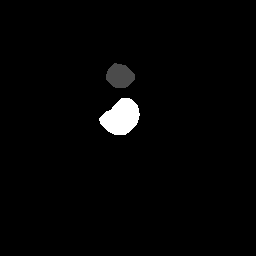

Slice location:  25


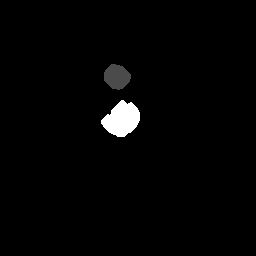

Total numbers of usable slices segmented: 5


In [ ]:
if not debug_mode:
  %%capture

# Remove colors of selection
def bandpass_filter(img, color1=225, color2=800):
    # Replace out-off-range colors with black\
    img[img<color1] = 0
    img[img>color2] = 0
    return img


# Take input image and area, remove any objects smaller than the defined area
def undesired_objects(binary_map, area, check):
  # do connected components processing
  nlabels, labels, stats, centroids = cv.connectedComponentsWithStats(cv.bitwise_not(binary_map), None, None, None, 8, cv.CV_32S)

  #get CC_STAT_AREA component as stats[label, COLUMN] 
  areas = stats[1:,cv.CC_STAT_AREA]

  result = np.zeros((labels.shape), np.uint8)
  for i in range(0, nlabels - 1):
      if areas[i] >= area:   #keep
          result[labels == i + 1] = 255
      if areas[i] >= area3 and check==2:
          result[labels == i + 1] = 0
  return cv.bitwise_not(result)


# Filter out both black and white connected components
def filter_2D(img, area1=1000, area2=100):
  # Creating kernel
  kernel = np.ones((2, 2), np.uint8)
  th2 = cv.erode(img, kernel, iterations = 1)
  # Remove small objects two-directionally
  result = undesired_objects(th2, area1, 1)
  print("Black components filtered")
  cv2_imshow(result)
  result = cv.bitwise_not(undesired_objects(cv.bitwise_not(result), area2, 2))
  print("White components filtered")
  cv2_imshow(result)
  result = cv.dilate(result, kernel, iterations = 1)
  return result


# Hough localization to detect LA center
def hough_localization(img_series):
  c_x = []
  c_y = []
  for img in img_series:
    # Hough localization
    img_blur = cv.medianBlur(img.copy(),5)
    img_blur = (img_blur/np.max(img_blur)) * 255
    np.clip(img_blur, 0, 255, out=img_blur)
    img_blur = img_blur.astype('uint8')
    rows = img_blur.shape[0]
    circles = cv.HoughCircles(img_blur, cv.HOUGH_GRADIENT, 1, rows, param1=80, param2=hough_thresh, minRadius=minR, maxRadius=maxR)
    RA_center = None
    if circles is not None:
      circles = np.uint16(np.around(circles))
      for c in circles[0,:]:
          # draw the outer circle
          cv.circle(img_blur,(c[0],c[1]),c[2],(0,255,0),2)
          # draw the center of the circle
          cv.circle(img_blur,(c[0],c[1]),2,(0,0,255),3)
          c_x.append(c[0])
          c_y.append(c[1])
      cv2_imshow(img_blur)
    RA_center = [np.median(c_x), np.median(c_y)]
    return RA_center


# Find closest point in array
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argmin(dist_2)


# Find nearest value in array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


# Identify and out RA and LA mask
def chamber_localization(img, LA_center):
    nlabels, labels, stats, centroids = cv.connectedComponentsWithStats(img, None, None, None, 4, cv.CV_32S)
    # If not enough regions can be identified
    if LA_center is None:
      return None, None, None, None, None

    centroids = centroids[1:]
    if nlabels == 6:
      # Sort centroids and identify the RA and LA
      draw_image = img.copy()
      centroids = centroids[centroids[:, 1].argsort()]
      c_RA = centroids[3]
      RA_label = labels[int(c_RA[1]), int(c_RA[0])]
      cv.circle(draw_image, (int(c_RA[0]), int(c_RA[1])), 1, (0, 0, 0), 1)
      print("Localized ")
      cv2_imshow(draw_image)

      centroids_top = centroids[0:3]
      c_LA = centroids_top[centroids_top[:, 0].argsort()][-1]
      LA_label = labels[int(c_LA[1]), int(c_LA[0])]
      cv.circle(draw_image, (int(c_LA[0]), int(c_LA[1])), 1, (0, 0, 0), 1)
      cv2_imshow(draw_image)

    else:
      draw_image = img.copy()
      c_LA = centroids[closest_node(LA_center, centroids)]

      LA_label = labels[int(c_LA[1]), int(c_LA[0])]
      cv.circle(draw_image, (int(c_LA[0]), int(c_LA[1])), 1, (0, 0, 0), 1)
      print("Localized ")
      cv2_imshow(draw_image)

      centroids_y = centroids[:,1]
      below_LA_pts = centroids[(centroids_y>c_LA[1]) & (centroids_y>(c_LA[1]+25))]
      below_LA_x = below_LA_pts[:,0]
      below_LA_pts = below_LA_pts[(below_LA_x>(c_LA[0]+30)) | (below_LA_x>(c_LA[0]-30))]
      try:
        c_RA = below_LA_pts[below_LA_pts[:, 1].argsort()][0]
        RA_label = labels[int(c_RA[1]), int(c_RA[0])]
        cv.circle(draw_image, (int(c_RA[0]), int(c_RA[1])), 1, (0, 0, 0), 1)
        cv2_imshow(draw_image)
      except:
        return None, None, None, None, None
    # get CC_STAT_AREA component as stats[label, COLUMN] 
    areas = stats[1:,cv.CC_STAT_AREA]
    result = np.zeros((labels.shape), np.uint8)
    result[labels == RA_label] = 255
    result[labels == LA_label] = 75
    cv2_imshow(result)
    dilated_result = cv.dilate(result, cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3)), iterations=erode_iterations+1)
    cv2_imshow(dilated_result)

    return areas[LA_label-1], areas[RA_label-1], c_LA, c_RA, dilated_result

def reject_outliers(data, m = outlier_threshold):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return (s<m)


# Run segmentation
segmented_masks = []
seg_slice_locs = []
slice_count = 0
LA_centers = []
RA_centers = []
LA_areas = []
RA_areas = []
if __name__ == "__main__":
  for i in range(len(img_series)):
    img = img_series[i]

    print("LA center")
    LA_center = hough_localization(img_series)

    print("Color Filtered")
    filtered_img = bandpass_filter(img.copy(), color1, color2)
    filtered_img = (filtered_img/np.max(filtered_img)) * 255
    np.clip(filtered_img, 0, 255, out=filtered_img)
    filtered_img = filtered_img.astype('uint8')
    cv2_imshow(filtered_img)

    print("Adaptive Thresholded")
    th = cv.adaptiveThreshold(filtered_img,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, blockSize, C)
    cv2_imshow(th)
    th = cv.erode(th, cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2)))
    area_filtered_img = filter_2D(th, area1, area2)

    print("Eroded")
    eroded_img = cv.erode(area_filtered_img, cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3)), iterations=erode_iterations)
    cv2_imshow(eroded_img)
    area_filtered_img2 = filter_2D(eroded_img, area1*2, area2*0.4)

    a_LA, a_RA, c_LA, c_RA, segmention_mask = chamber_localization(area_filtered_img2, LA_center)
    if segmention_mask is not None:
      segmented_masks.append(segmention_mask)
      
      LA_centers.append(np.array(list(c_LA)))
      RA_centers.append(np.array(list(c_RA)))
      LA_areas.append(a_LA)
      RA_areas.append(a_RA)
    slice_count+=5
    seg_slice_locs.append(slice_count)
    
segmented_masks = np.array(segmented_masks)
seg_slice_locs = np.array(seg_slice_locs)
LA_centers = np.array(LA_centers)
RA_centers = np.array(RA_centers)
LA_areas = np.array(LA_areas)
RA_areas = np.array(RA_areas)

# Delete outliers if any
print(segmented_masks.shape)
LA_outliers_idx = (reject_outliers(LA_centers[:, 0])) & (reject_outliers(LA_centers[:, 1]))
RA_outliers_idx = (reject_outliers(RA_centers[:, 0])) & (reject_outliers(RA_centers[:, 1]))
LA_outliers_idx2 = (reject_outliers(LA_areas)) & (reject_outliers(LA_areas))
RA_outliers_idx2 = (reject_outliers(RA_areas)) & (reject_outliers(RA_areas))
segmented_masks = segmented_masks[(LA_outliers_idx)&(RA_outliers_idx)&(LA_outliers_idx2)&(RA_outliers_idx2)]
seg_slice_locs = seg_slice_locs[(LA_outliers_idx)&(RA_outliers_idx)&(LA_outliers_idx2)&(RA_outliers_idx2)]

print("Accepted segmentation masks: ")
for i in range(len(segmented_masks)):
  print("Slice location: ", seg_slice_locs[i])
  cv2_imshow(segmented_masks[i])

print("Total numbers of usable slices segmented:", len(segmented_masks))

# **Contour Extraction**

[ 5 10 15 20 25]


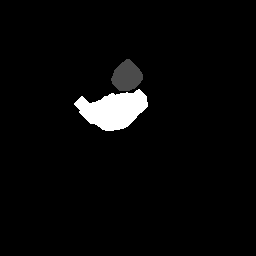

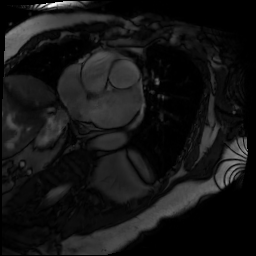

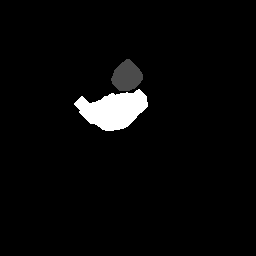

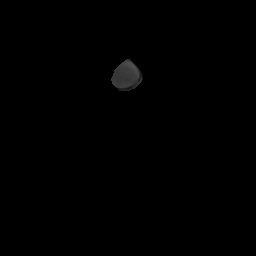

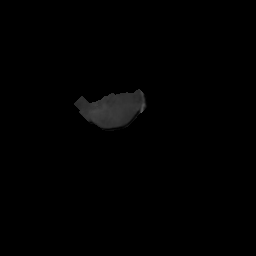

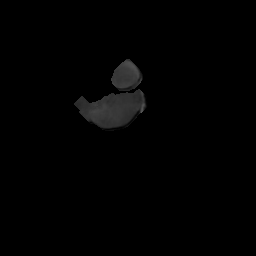

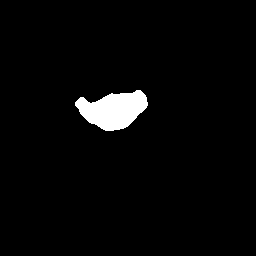

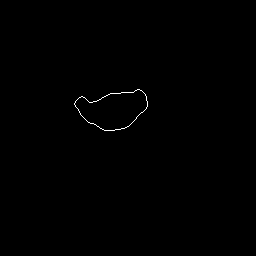

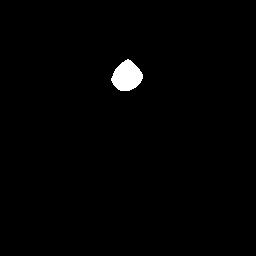

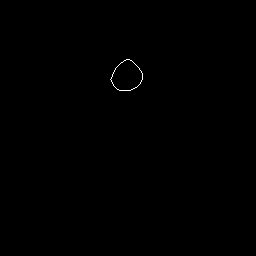

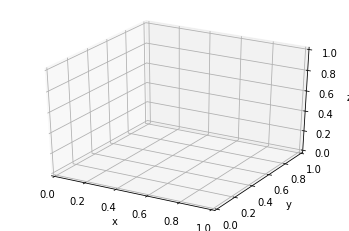

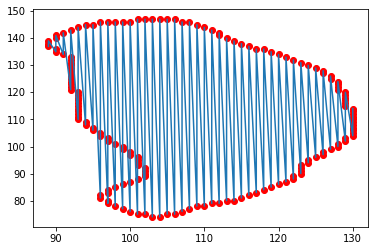

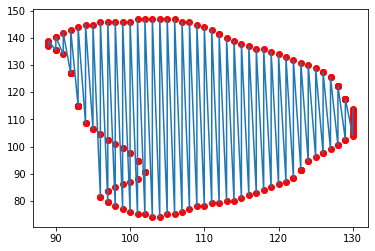

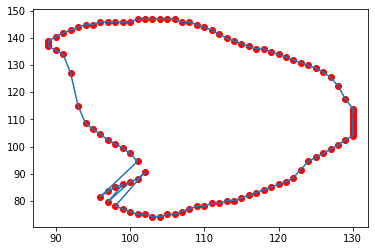

/usr/local/lib/python3.7/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][106]=x[1][0]
  (i, m, i)))


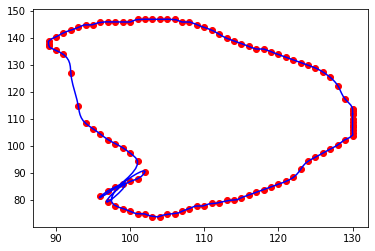

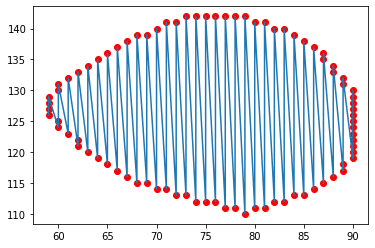

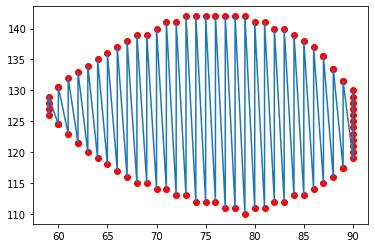

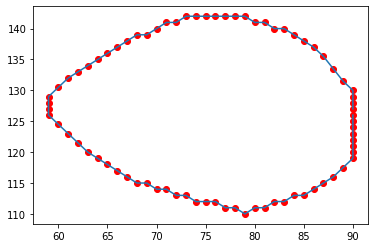

/usr/local/lib/python3.7/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][76]=x[1][0]
  (i, m, i)))


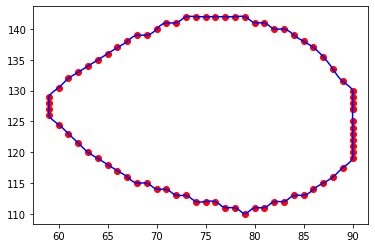

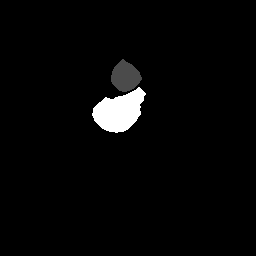

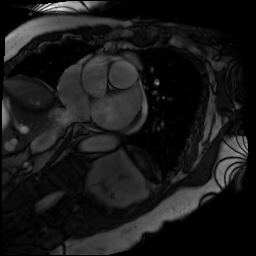

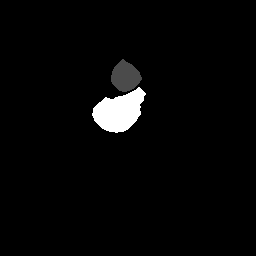

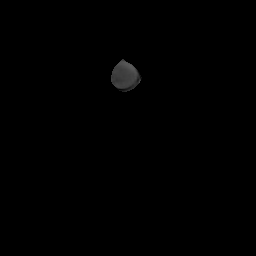

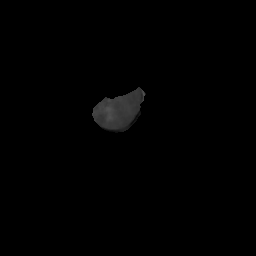

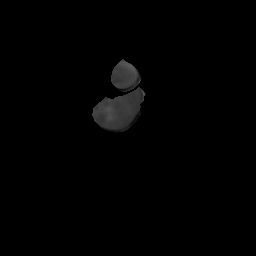

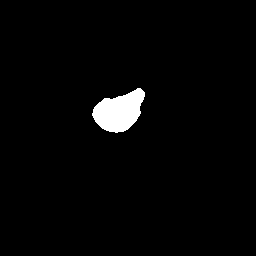

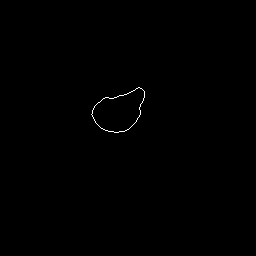

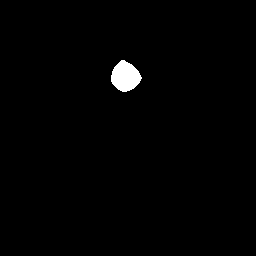

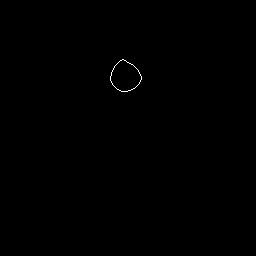

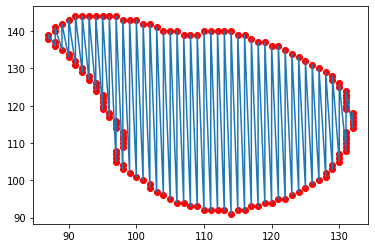

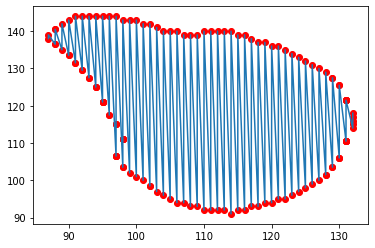

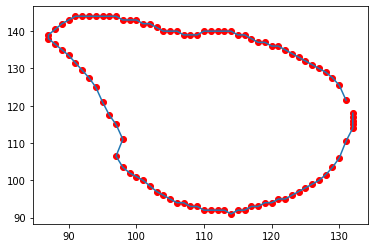

/usr/local/lib/python3.7/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][97]=x[0][0]
  (i, m, i)))
/usr/local/lib/python3.7/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][97]=x[1][0]
  (i, m, i)))


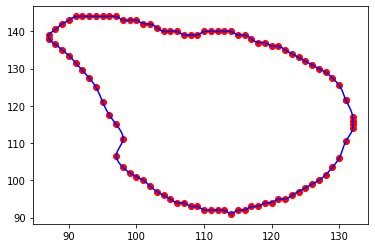

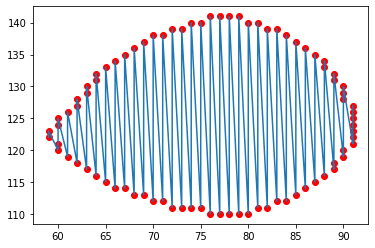

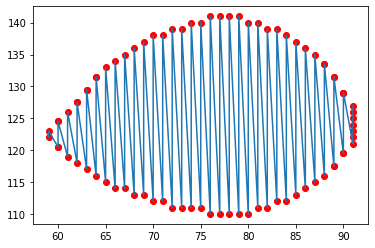

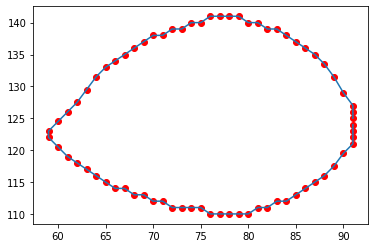

/usr/local/lib/python3.7/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][71]=x[1][0]
  (i, m, i)))


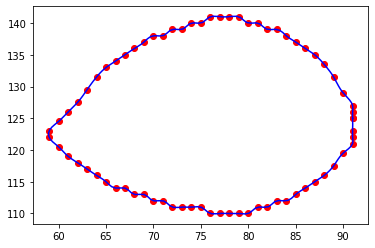

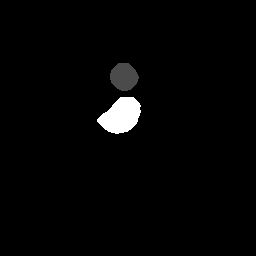

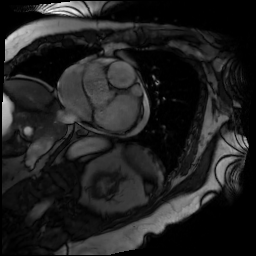

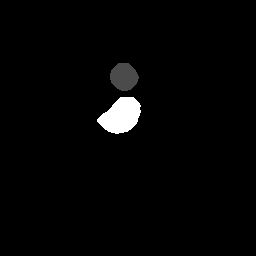

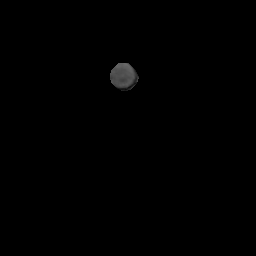

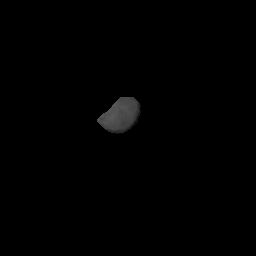

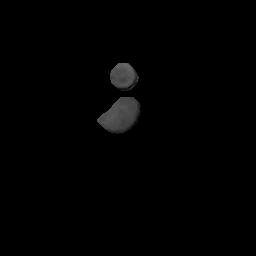

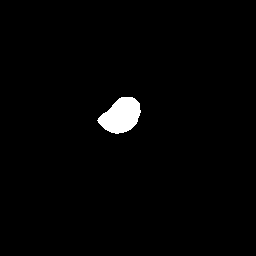

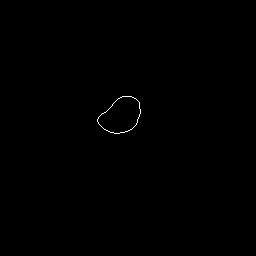

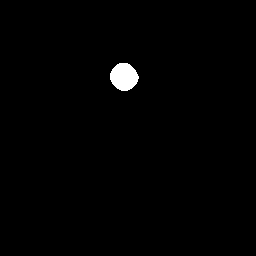

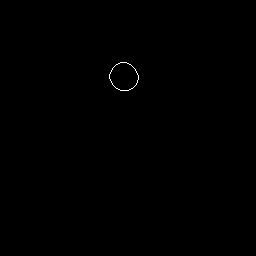

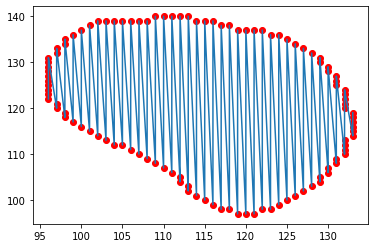

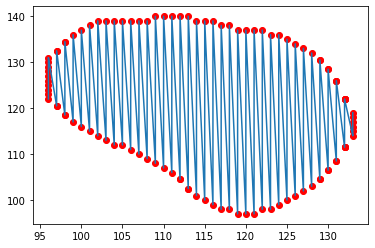

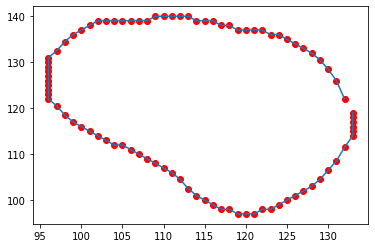

/usr/local/lib/python3.7/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][88]=x[0][0]
  (i, m, i)))
/usr/local/lib/python3.7/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][88]=x[1][0]
  (i, m, i)))


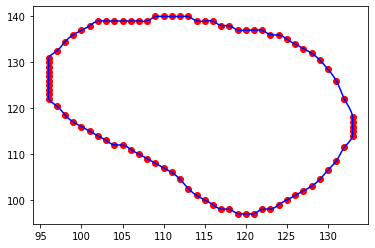

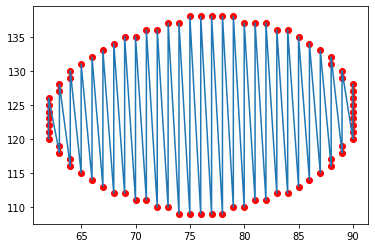

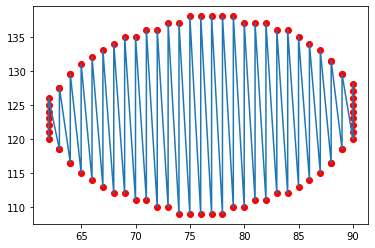

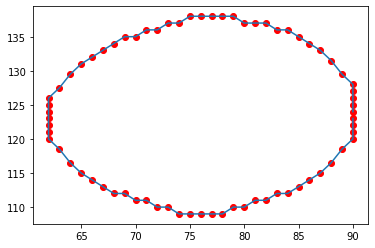

/usr/local/lib/python3.7/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][70]=x[1][0]
  (i, m, i)))


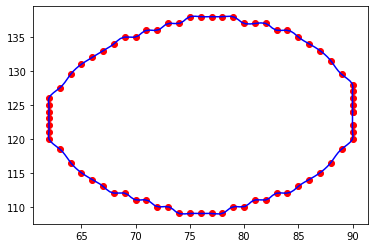

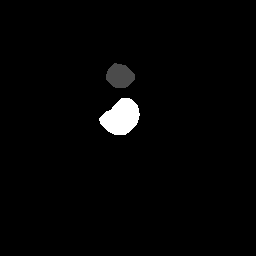

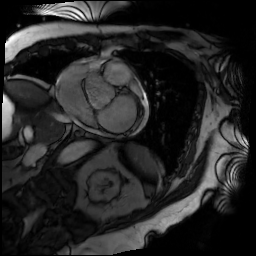

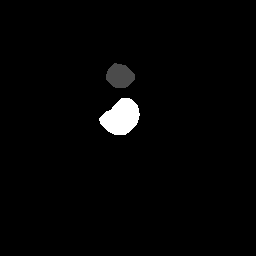

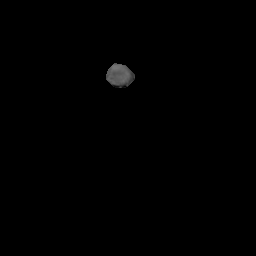

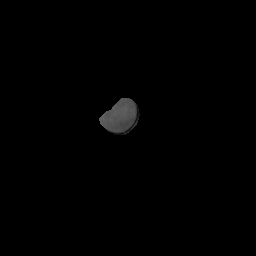

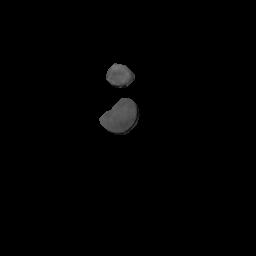

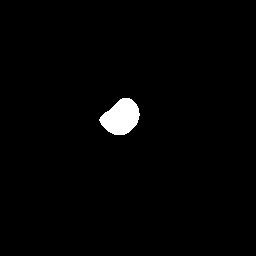

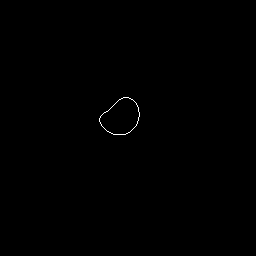

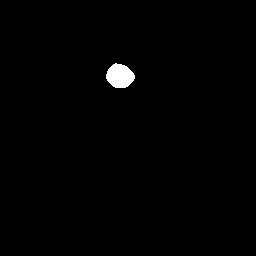

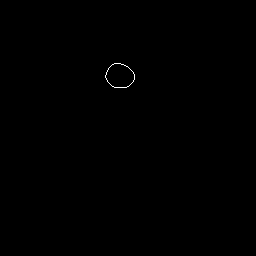

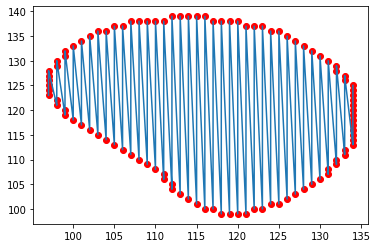

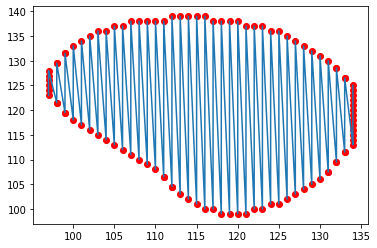

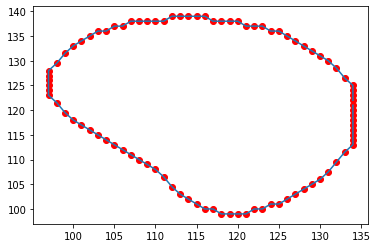

/usr/local/lib/python3.7/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][91]=x[1][0]
  (i, m, i)))


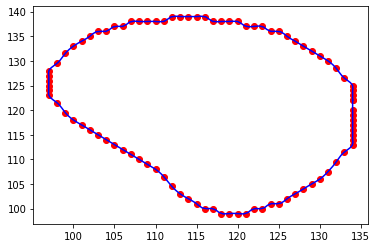

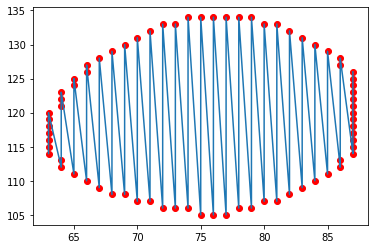

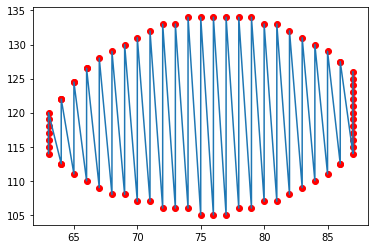

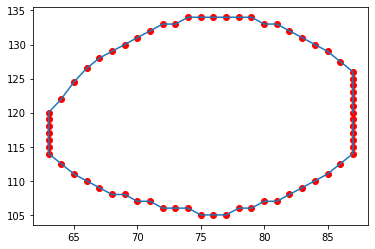

/usr/local/lib/python3.7/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][66]=x[1][0]
  (i, m, i)))


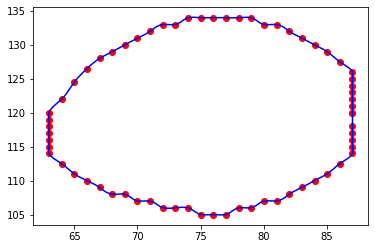

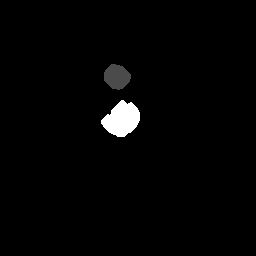

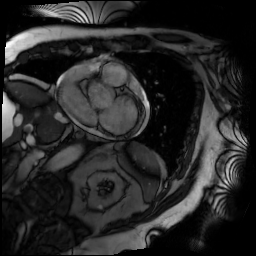

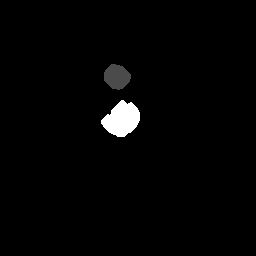

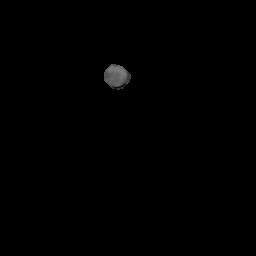

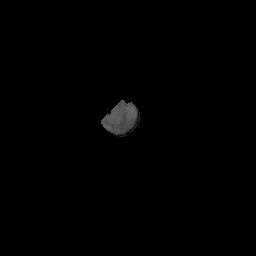

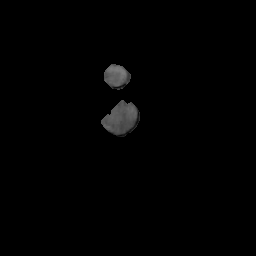

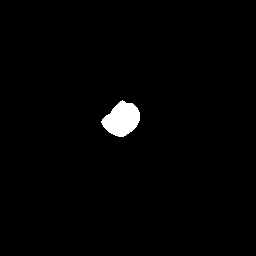

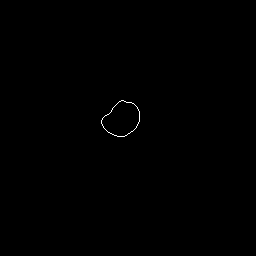

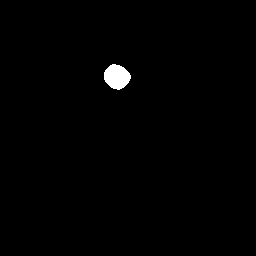

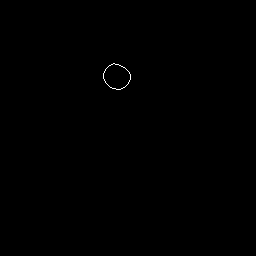

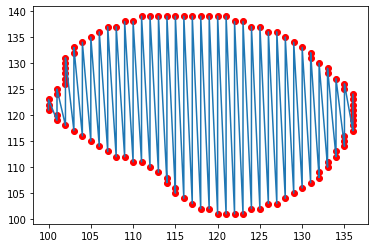

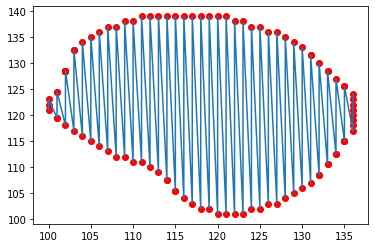

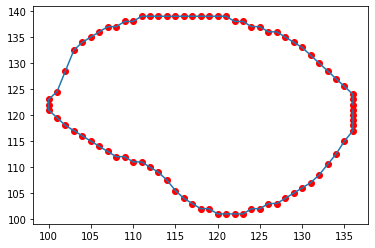

/usr/local/lib/python3.7/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][81]=x[1][0]
  (i, m, i)))


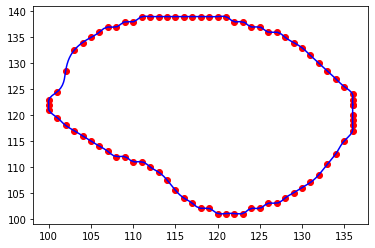

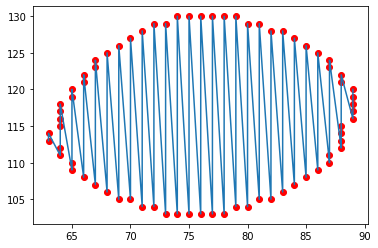

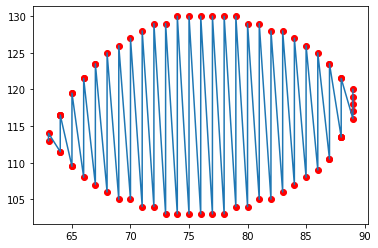

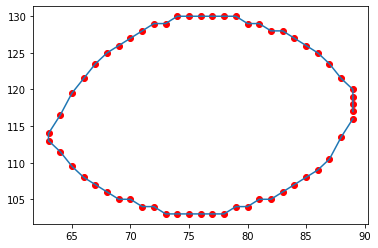

/usr/local/lib/python3.7/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][57]=x[1][0]
  (i, m, i)))


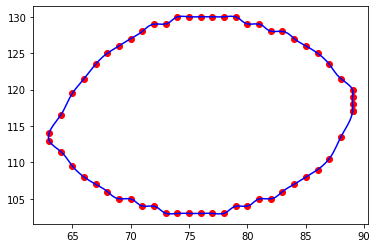

In [ ]:
if not debug_mode:
  %%capture

tiff2=[]
def apply_mask(img, mask):
  np.clip(img, 0, 255, out=img)
  img = img.astype('uint8')

  RA_mask = np.where(mask==255,255,0)
  np.clip(RA_mask, 0, 255, out=RA_mask)
  RA_mask = RA_mask.astype('uint8')

  LA_mask = np.where(mask==75,255,0)
  np.clip(LA_mask, 0, 255, out=LA_mask)
  LA_mask = LA_mask.astype('uint8')

  RA = cv.bitwise_and(img.copy(), img.copy(), mask = RA_mask)
  LA = cv.bitwise_and(img.copy(), img.copy(), mask = LA_mask)
  full_mask = np.where(mask!=0,255,0)
  np.clip(full_mask, 0, 255, out=full_mask)
  full_mask = full_mask.astype('uint8')
  full = cv.bitwise_and(img.copy(), img.copy(), mask = full_mask)

  return LA, RA, full

def reconstruction_full(img, mask, LA_mean, MY_mean):
  mask_copy = mask.copy()
  mask_copy2 = mask.copy()

  # Make areas less than LA holes
  mask_copy2[mask==255] = 0
  mask_copy2[np.around(np.around(mask_copy2/10)*10)==60] = 255

  np.clip(mask_copy2, 0, 255, out=mask_copy2)
  mask_copy2 = mask_copy2.astype('uint8') 
  nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_copy2, None, None, None, 4, cv2.CV_32S)
  areas = stats[1:,cv.CC_STAT_AREA]
  shape_max_label = np.argmax(areas)+1
  for i in range(0, nlabels - 1):
    if i+1 != shape_max_label:
      mask[labels == i+1] = 0

  # Fill holes
  mask[mask!=0] = 255
  np.clip(mask, 0, 255, out=mask)
  mask = mask.astype('uint8') 
  mask = cv2.bitwise_not(mask)
  holes = undesired_objects(mask, 100)
  nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(holes, None, None, None, 4, cv2.CV_32S)
  for i in range(0, nlabels - 1):  
    hole = np.zeros((labels.shape), np.uint8)
    hole[labels == i + 1] = 255
    hole_mean = np.mean(cv.bitwise_and(img.copy(), img.copy(), mask = hole))

    # If hole color closer to LA
    if np.abs(hole_mean-LA_mean) < np.abs(hole_mean-MY_mean):
      mask_copy[labels == i + 1] = 60
    else:
      mask_copy[labels == i + 1] = 255

  return mask_copy

def edge_detection(img):
  # Blur the image for better edge detection
  img_blur = cv2.medianBlur(img, 5)
  cv2_imshow(img_blur)
  # Canny Edge Detection
  edges = cv2.Canny(image=img_blur, threshold1=0, threshold2=0) # Canny Edge Detection

  contours, h = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  
  big_contour = max(contours, key=cv2.contourArea)
  M = cv2.moments(big_contour)
  cX = int(M["m10"] / M["m00"])
  cY = int(M["m01"] / M["m00"])

  result = np.zeros((img_blur.shape), np.uint8)
  cv2.drawContours(result, contours, -1, (255,255,255), thickness = 1)

  # Display Canny Edge Detection Image
  cv2_imshow(result)
  return result, [cX,cY]

def get_normal_vec(points):
  p1=np.array(points[0])
  p2=np.array(points[1])
  p3=np.array(points[2])
  # These two vectors are in the plane
  v1 = p3 - p1
  v2 = p2 - p1
  # The cross product is a vector normal to the plane
  return np.cross(v1, v2)


def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def f7(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]
def sort_xy(x, y):

    x0 = np.mean(x)
    y0 = np.mean(y)

    r = np.sqrt((x-x0)**2 + (y-y0)**2)

    angles = np.where((y-y0) > 0, np.arccos((x-x0)/r), 2*np.pi-np.arccos((x-x0)/r))

    mask = np.argsort(angles)

    x_sorted = x[mask]
    y_sorted = y[mask]

    return x_sorted, y_sorted

from collections import OrderedDict
def extract_ring_path(indices, z_shape=False, spline=True):
  ring_indices = [[],[]]
  x_idx_array = [[]]
  count = 0

  # Conpensate low resolution
  for i in range(len(indices[0])):
    x_array = indices[0]
    y_array = indices[1]

    x = x_array[i]
    y = y_array[i]
    if i in list(x_idx_array[0]):
      continue

    x_idx_array = np.where(x_array == x)
    y_idx_array = np.where(y_array == y)
    consecutive_y = consecutive(y_array[x_idx_array])
    # If straight line
    if len(consecutive_y)==1:
      ring_indices[0].extend(indices[0][x_idx_array])
      ring_indices[1].extend(indices[1][x_idx_array])
     
    # Seperate groupes alone y
    if len(consecutive_y)>=2:
      ring_indices[0].extend(indices[0][x_idx_array])
      for j in range(len(consecutive_y)):
        group_len = len(consecutive_y[j])
        ring_indices[1].extend([np.mean(consecutive_y[j])]*group_len)
  

  plt.figure()
  plt.plot(indices[0], indices[1], "ro")
  plt.plot(indices[0], indices[1])
  plt.show()
  
  plt.figure()
  plt.plot(ring_indices[0], ring_indices[1], "ro")
  plt.plot(ring_indices[0], ring_indices[1])
  plt.show()

  plt.figure()
  L = np.unique(np.array(list(zip(ring_indices[0], ring_indices[1]))), axis=0)
  L = L.T
  x_new, y_new = sort_xy(np.array(L[0]), np.array(L[1]))
  plt.plot(x_new, y_new, "ro")
  plt.plot(x_new, y_new)
  plt.show()
  ordered_ring_coords = np.array(list(zip(x_new, y_new)))


  if spline:
    
    tck, u = splprep(ordered_ring_coords.T, u=None, s=0.0, per=1) 
    u_new = np.linspace(u.min(), u.max(), 200)
    x_new, y_new = splev(u_new, tck, der=0)
    if z_shape:
      print(u_new)
    plt.figure()
    plt.plot(ordered_ring_coords[:, 0], ordered_ring_coords[:, 1], "ro")
    plt.plot(x_new, y_new, 'b-')
    plt.show()
  return x_new, y_new


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

def generate_xzy(indices, z_depth, center_diff_x=0, center_diff_y=0, scatter=True):
  coordinates = np.array([indices[0]+center_diff_x, indices[1]+center_diff_y, np.array(np.shape(indices)[1]*[z_depth])])
  
  if scatter:
    ax.scatter(coordinates[0], coordinates[1], coordinates[2])
  else:
    ax.plot(coordinates[0], coordinates[1], coordinates[2], "r-")
  fig.show()
  coordinates_zipped = list(zip(coordinates[0], coordinates[1], coordinates[2]))
 
  coordinates = np.array([indices[0], indices[1], np.array(np.shape(indices)[1]*[z_depth]), np.array(np.shape(indices)[1] * [255]), np.array(np.shape(indices)[1] * [255]), np.array(np.shape(indices)[1] * [255])])

  coordinates_zipped = list(zip(coordinates[0], coordinates[1], coordinates[2], coordinates[3], coordinates[4], coordinates[5]))
  return coordinates_zipped

def save_xzys(xyz_array, filename):
  xyz_array = [item for sublist in xyz_array for item in sublist]
  xyz_array_np = []

  xyz_array_np = np.array(xyz_array)
  np.savetxt('/content/gdrive/MyDrive/'+filename, xyz_array_np, delimiter=',') 

def reconstruct_tip(edge, num_img, range=[0.9, 0.01]):
  sizes = np.linspace(range[0], range[1], num=num_img)
  l_dim = np.shape(edge)[0]

  reconstructed_shapes = []
  for size in sizes:
    small = cv2.resize(edge, (0,0), fx=size, fy=size) 
    s_dim = np.shape(small)[0]

    x_offset=y_offset=round((l_dim-s_dim)/2)

    result = np.zeros((edge.shape), np.uint8)
    result[y_offset:y_offset+small.shape[0], x_offset:x_offset+small.shape[1]] = small
    cv2_imshow(small)
    cv2_imshow(result)
    reconstructed_shapes.append(result)
  return reconstructed_shapes



tiff = segmented_masks
unsupervised_seg_imgs = img_series

xyz_array_RA = []
xyz_array_LA = []
tiff_copy = tiff.copy()
centroids_list = []
ring_list_RA = []
ring_list_LA = []

LA_mask_arr = []
MY_mask_arr = []
edges_LA = []
edges_MY = []
full_arr = []
z_depth1 = 0
z_depth2 = 0
print(seg_slice_locs)
for i in range(len(tiff)):

  cv2_imshow(tiff_copy[i])
  reconstructed = tiff_copy[i]
  tiff2.append(reconstructed)
  np.clip(reconstructed, 0, 255, out=reconstructed)
  reconstructed = reconstructed.astype('uint8')
  _, _, _, centroids = cv2.connectedComponentsWithStats(reconstructed, None, None, None, 4, cv2.CV_32S)

  original = (unsupervised_seg_imgs[i]/np.max(unsupervised_seg_imgs[i])) * 255
  np.clip(original, 0, 255, out=original)
  original = original.astype('uint8')
  cv2_imshow(original)
  LA, RA, full = apply_mask(original,reconstructed)
  full_arr.append(full)
  cv2_imshow(reconstructed)
  cv2_imshow(LA)
  cv2_imshow(RA)
  cv2_imshow(full)
  RA_solid = reconstructed.copy()
  RA_solid[RA_solid!=255] = 0
  MY_mask_arr.append(RA_solid)
  edges, _ = edge_detection(RA_solid)
  edges_MY.append(edges)

  LA_solid = reconstructed.copy()
  LA_solid[LA_solid==255] = 0
  LA_solid[LA_solid!=0] = 255
  LA_mask_arr.append(LA_solid)
  edges2, _= edge_detection(LA_solid)
  edges_LA.append(edges2)

  indices = np.array(np.where(edges!= [0]))
  ring_x, ring_y = extract_ring_path(indices)
  xyz_array_RA.append(generate_xzy([ring_x, ring_y], z_depth1, scatter=False))
  ring_list_RA.append([ring_x, ring_y, np.array(len(ring_x)*[z_depth1])])
  z_depth1 = seg_slice_locs[i]

 
  indices = np.array(np.where(edges2!= [0]))
  ring_x, ring_y = extract_ring_path(indices)
  xyz_array_LA.append(generate_xzy([ring_x, ring_y], z_depth2, scatter=False))
  ring_list_LA.append([ring_x, ring_y, np.array(len(ring_x)*[z_depth2])])
  z_depth2 = seg_slice_locs[i]



ring_list_RA=np.array(ring_list_RA)
ring_list_LA=np.array(ring_list_LA)
save_xzys(xyz_array_RA, "RA_point_cloud.xyz")
save_xzys(xyz_array_LA, "LA_point_cloud.xyz")
fig.show()
imageio.mimwrite("3D_LA_mask.tiff", LA_mask_arr)
imageio.mimwrite("3D_RA_mask.tiff", MY_mask_arr)
imageio.mimwrite("3D_mask.tiff", tiff2)
imageio.mimwrite("3D_segmented.tiff", full_arr)
imageio.mimwrite("3D_edges_LA.tiff", edges_LA)
imageio.mimwrite("3D_edges_LA.tiff", edges_MY)